# Tutorial on the STM workflow

### In this tutorial we present the characteristics of the STM workflow. The aim is to present the characteristics of this workflow and the various tools that accompany it

In [30]:
from aiida import load_profile, orm, engine
import numpy as np
profile = load_profile()

In [8]:
def load_or_submit(builder, uuid=None):
    if uuid is not None:
        return load_node(uuid)
    calc = engine.submit(builder)
    print('submitted', calc)
    return calc

In [35]:
from aiida_kkr.workflows import kkr_imp_sub_wc

example_calc = orm.load_node('73e4ca38-38ed-4ec2-b11a-87b03e0f0635')
imp_scf = example_calc.inputs.imp_scf.startpot.get_incoming(node_class=kkr_imp_sub_wc).first().node.caller
last_imp_calc = orm.load_node(imp_scf.outputs.last_calc_info['last_calc_nodeinfo']['uuid'])

# This must go to the wf inputs
imp_info = imp_scf.inputs.impurity_info

# After this we retrieve the host calculation
host_calc = imp_scf.inputs.remote_data_host.get_incoming(node_class=orm.CalcJobNode).first().node
# In particular the remote folder, this contains the structural data of the system.
host_remote = host_calc.outputs.remote_folder

imp_potential_node = imp_scf.outputs.converged_potential

### Now we show one of the tools of the workflow: The STM pathfinder, which is able to decide which sites are going to be scanned based on the symmetries of the system.

In [4]:
from aiida_kkr.tools.tools_STM_scan import STM_pathfinder

# The pathfinder is able to find the structural information of the system, and the matrix representation of the system's symmetries
struc_info, symm_matrices = STM_pathfinder(host_remote)

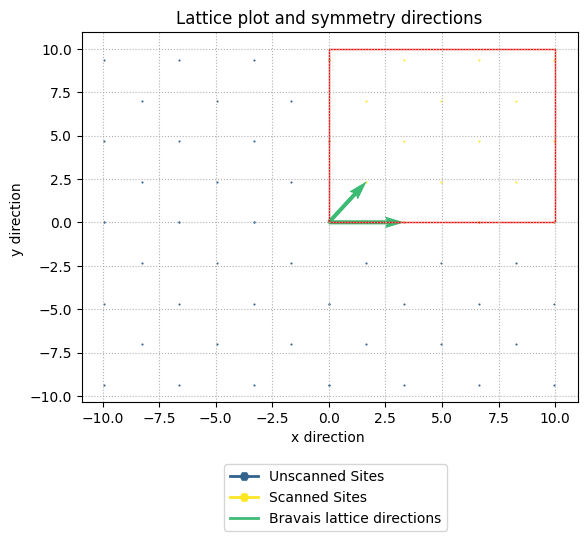

In [6]:
from aiida_kkr.tools.tools_STM_scan import lattice_plot

# We now use the lattice plot tool to have a clear representation of the scanning sites.

symm_matrices = [np.array([[1., 0.],
        [0., 1.]]),
 np.array([[-1.,  0.],
        [ 0., -1.]]),
 np.array([[ 1.,  0.],
        [ 0., -1.]]),
 np.array([[-1.,  0.],
        [ 0.,  1.]])]

lattice_length_x = 10 # In Angstrom
lattice_length_y = 10 


# Save the positions to be scanned into an array, this can be used to manually submit the calculation
points = lattice_plot(struc_info['plane_vectors'], False, symm_matrices, lattice_length_x, lattice_length_y)

## Manual tool for the retrival and use of the positions 

In [7]:
from aiida_kkr.tools.tools_STM_scan import lattice_generation, find_linear_combination_coefficients

functioning_scanning  = []
for element in points:
    for pos in element:
        functioning_scanning.append(pos)
        
#eliminate, scan = lattice_generation(30, 30, mat, 0, 0, [[3.31, 0.0], [1.655, 2.3405234457275]])

coeff = find_linear_combination_coefficients([[3.31, 0.0], [1.655, 2.3405234457275]], functioning_scanning)

# Sometimes the number of point that need to be scanned is to big to be handled. In such cases it is advisiable to split the calculations
# in multiple sections, each containing a stripe of the region that need to be scanned, and then submit them with the Group submission

#split_arr = np.array_split(coeff, 20)

### Once we have a clearer idea of the positions we will investigate we can use the STM workflow itself

In [40]:
from aiida_kkr.workflows import kkr_STM_wc

builder = kkr_STM_wc.get_builder()

# The impurity info is a dictionary containing the impurity type, it's position and cluster radius
builder.imp_info = imp_info

# Host remote is the RemoteData containing information about the structure of the host system
builder.host_remote = host_remote

# The impurity potential node contains a file where all the information about the potential generated by an impurity.
builder.imp_potential_node = imp_potential_node

# The tip position is where we want to scan with the STM. 
# ilayer is the z position of the tip
# nx and ny are the number of sites to be scanned in the unit of the in-plane Bravais lattice (da and db respectively)

# NOTE: The automatic submission is broken at this moment since the ASE tool doesn't return the correct rotation matrix
# Instead use the parameter "scan positions"
builder.tip_position = orm.Dict({'ilayer': 0, 'nx': 10, 'ny': 10,  'scan_positions':coeff})

# This paramters controls the cluster radius on the KKR level, sometimes it must be increased in order to allow for
# the calculation of the impurity cluster
builder.gf_writeout.params_kkr_overwrite = orm.Dict(dict={'NSHELD': 1000})

#builder.remote_data = remote_data_folder
#builder.kkrflex_files = kkrflex_files_folder
#builder = kkr_imp_dos_wc.get_builder()

builder.wf_parameters = orm.Dict(dict={
    'jij_run': False,
    'lmdos': True,
    'retrieve_kkrflex': True,
    'dos_params': { 
        'tempr': 210.0,
        'kmesh': [100, 100, 1],
        'RCLUSTZ': None},
        'nepts': 7, # These last three parameters are set to some default value if not specified
        'emin': 0-0.0005, # These are the default parameters, change emin and emax in order to specifiy 
        'emax': 0+0.0005, # which energy region to scan, and adjust the nepts to select how many poits to use 
})

options = orm.Dict(dict={
    'max_wallclock_seconds': 4*3600, # max runtine
    'resources': {'num_machines': 1 , 'num_mpiprocs_per_machine': 7},
    'queue_name': 'c23ms',
    'custom_scheduler_commands': '#SBATCH --account=p0021406',
    'withmpi': True
})
builder.options = options

#builder.kkr = orm.Code.get_from_string('KKRhost@JURECA-DC-STAGE2024')
#builder.kkrimp = orm.Code.get_from_string('KKRimp@JURECA-DC-STAGE2024')

#builder.kkr = Code.get_from_string('kkrhost_BdG_AMD@iffslurm')
#builder.kkrimp = Code.get_from_string('KKRIMP_BdG@iffslurm')

builder.kkr = orm.Code.get_from_string('kkrhost@claix18aiida')
builder.kkrimp = orm.Code.get_from_string('kkrimp@claix18aiida')

STM_example = load_or_submit(builder, '0a8f56ed-0d50-47c9-8322-337462fba208')

submitted uuid: 0a8f56ed-0d50-47c9-8322-337462fba208 (pk: 218454) (aiida_kkr.workflows.kkr_STM.kkr_STM_wc)


In [54]:
!verdi process status 218454

17310.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


kkr_STM_wc<218454> Finished [0] [2:results]
    └── kkr_imp_dos_wc<218459> Finished [0] [2:return_results]
        ├── kkr_flex_wc<218462> Finished [0] [2:return_results]
        │   ├── update_params_wf<218464> Finished [0]
        │   ├── KkrCalculation<218467> Finished [0]
        │   └── create_out_dict_node<218472> Finished [0]
        ├── kkr_imp_sub_wc<218475> Finished [0] [2:error_handler]
        │   ├── kick_out_corestates_wf<218478> Finished [0]
        │   ├── KkrimpCalculation<218480> Finished [0]
        │   ├── extract_imp_pot_sfd<218484> Finished [0]
        │   └── create_out_dict_node<218487> Finished [0]
        ├── parse_impdosfiles<218493> Finished [0]
        ├── parse_impdosfiles<218500> Finished [0]
        └── create_out_dict_node<218504> Finished [0]


# Some tool for the plotting of the data 

## This parser uses is able to get the calculation both from single node and groups. But it assumes a 2 spin channel 

In [56]:
def STM_real_space_parser(STM_calc, energy_pos, N0):
    
    """ 
    STM_calc   : Single calculcation node or group with calculations
    energy_pos : energy that wants to be analysed
    N0         : Number of atoms in the original impurity cluster, these will not be considered
    """
    
    from masci_tools.util.constants import BOHR_A
    from time import time
    
    alat_ang = (6.267994199139 * BOHR_A)
    
    #plt.figure(figsize=(10,10))
    t0 = time()
    all_pos = [[], []]
    all_dat_summed_rho = []
    all_dat_summed_mu = []
    
    # grouping of node if a list of nodes is the input instead of a single node
    groupmode = False
    if type(STM_calc) == list:
        if len(STM_calc) > 1:
            groupmode = True
        else:
            STM_calc = STM_calc[0]
            
    if groupmode:
        
        for node in tqdm(STM_calc.nodes):
            
            with node.called[0].called[0].called[1].outputs.retrieved.open("kkrflex_atominfo") as _f:
                pos = np.loadtxt(_f, skiprows=3) * alat_ang
            
            try:
                dat = node.outputs.STM_dos_data_lmdos.get_y()[0][1]
            except:
                print('No STM data found!')
        
            for i in [-1,1]:
                for j in [-1,1]:
                    
                    all_pos[0] += list(i*pos[N0:,0])
                    all_pos[1] += list(j*pos[N0:,1])
                    all_dat_summed_rho += list(abs((dat[::2, energy_pos]+dat[1::2, energy_pos])[N0:])) #Both spin channels are considered here
                    all_dat_summed_mu  += list(abs((dat[::2, energy_pos]-dat[1::2, energy_pos])[N0:]))
        
    else:
        
        with STM_calc.called[0].called[0].called[1].outputs.retrieved.open("kkrflex_atominfo") as _f:
                pos = np.loadtxt(_f, skiprows=3) * alat_ang
            
        try:
            dat = STM_calc.outputs.STM_dos_data_lmdos.get_y()[0][1]
        except:
            print('No STM data found!')
       
        for i in [-1,1]:
            for j in [-1,1]:
             
                all_pos[0] += list(i*pos[N0:,0])
                all_pos[1] += list(j*pos[N0:,1])
                all_dat_summed_rho += list(abs((dat[::2, energy_pos]+dat[1::2, energy_pos])[N0:])) #Both spin channels are considered here
                all_dat_summed_mu  += list(abs((dat[::2, energy_pos]-dat[1::2, energy_pos])[N0:]))
        
    
    print(time()-t0)
    
    all_pos = np.array(all_pos)
    all_dat_summed_rho = np.array(all_dat_summed_rho)
    all_dat_summed_mu= np.array(all_dat_summed_mu)
    
    return all_pos, all_dat_summed_rho, all_dat_summed_mu

pos, rho, mu = STM_real_space_parser(STM_example, 9, 15)

0.3409569263458252


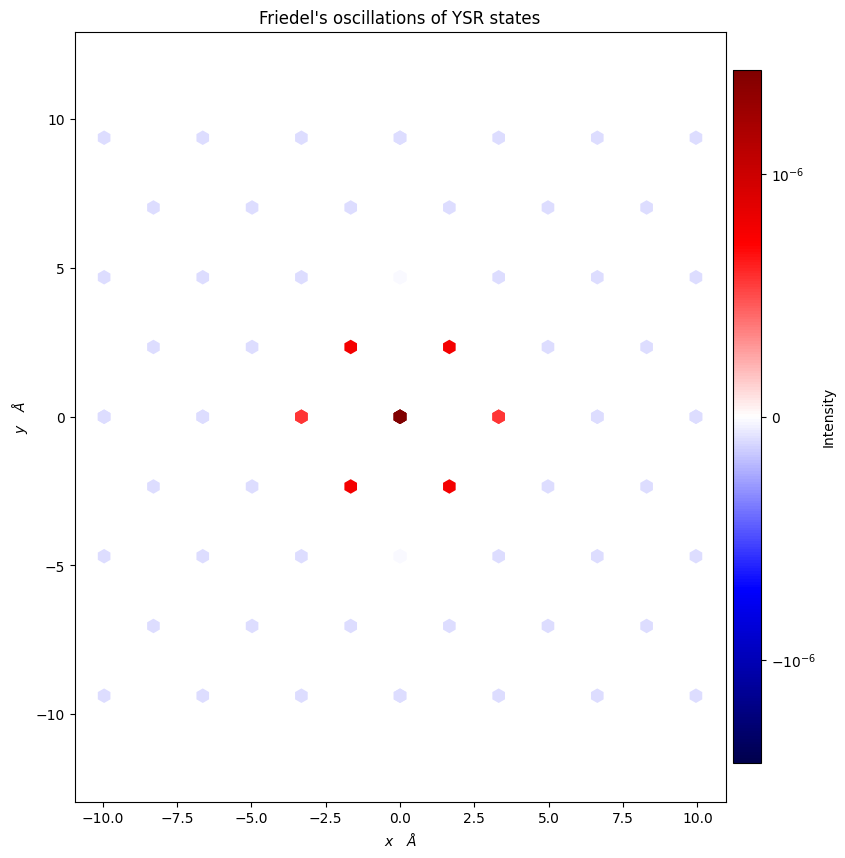

In [66]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors


R0 = 0 # internal radius (in Angstroms) that we don't want to plot
R1 = 0 # from which radius we want to exclude to take the mean

all_dat_aux = rho.copy()
all_dat3 = rho[np.sqrt(pos[0]**2+pos[1]**2)>R1] # support array, of these positions we will take the average to make the plot clearer 

all_dat_aux[np.sqrt(pos[0]**2+pos[1]**2)<R0] = np.NaN
plt.figure(figsize=(10,10))
plt.scatter(pos[0], pos[1], c=all_dat_aux-np.nanmean(all_dat3), cmap='seismic'
                       , s=110,  norm=colors.SymLogNorm(linthresh=0.000001), lw=0, marker ='h')

cl = plt.gci().get_clim()
cl = max(abs(cl[0]), cl[1])
plt.clim(-cl, cl)

#plt.gca().add_patch(Circle((0,0), 1.7, linewidth=1 , edgecolor='r', facecolor='red'))
plt.xlabel('$x \quad \AA$')
plt.ylabel('$y \quad \AA$')
plt.colorbar(orientation='vertical', aspect = 25, shrink = 0.9, pad=0.01, label = 'Intensity')
plt.axis("equal")

nan_mask = np.isnan(all_dat_aux)
nan_positions = np.argwhere(nan_mask)

for ps in nan_positions:
    x, y = all_pos[0][ps[0]], all_pos[1][ps[0]]  # Get the x, y position of NaN
    plt.scatter(x, y, marker='h', s = 110, color ='k')
#plt.axhline(15, ls=":", color="red")
#plt.axhline(8, ls=":", color="red")
#plt.axhline(5.5, ls=":", color="red")
#plt.axhline(3, ls=":", color="red")
#plt.ylim([-15, 7])
#plt.xlim([-7, 7])

plt.title("Friedel's oscillations")
plt.show()